In [1]:
# 使用MNIST数据集，MNIST相当于是机器学习界的helloworld
import sklearn 
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
#mnist=fetch_mldata('mnist-original', data_home='C:/Users/yzy/Desktop/MNIST_DATA')  这个方法暂时拿不到mnist

In [2]:
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist=input_data.read_data_sets("MNIST")

Extracting MNIST\train-images-idx3-ubyte.gz
Extracting MNIST\train-labels-idx1-ubyte.gz
Extracting MNIST\t10k-images-idx3-ubyte.gz
Extracting MNIST\t10k-labels-idx1-ubyte.gz


In [3]:
trainmnist=mnist.train.images
testmnist=mnist.test.images
trainlabelmnist=mnist.train.labels
testlabelmnist=mnist.test.labels

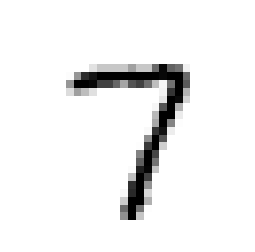

In [6]:
# 画出大概的图像来看一看
import matplotlib.pyplot as plt
import matplotlib
target_image=trainmnist[100] # 提取某一行
target_image_mm=target_image.reshape(28,28) # 每一个像素点大概是28*28大小
plt.imshow(target_image_mm,cmap='binary',interpolation='nearest')
plt.axis('off')
plt.show()
plt.close()

In [7]:
# 我们先训练一个二分类器
trainlabelmnist_5=(trainlabelmnist==5)
testlabelmnist_5=(testlabelmnist==5)

In [8]:
# 使用随机梯度下降分类方法
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(random_state=42)
sgdc.fit(trainmnist,trainlabelmnist_5)

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [9]:
from sklearn.model_selection import cross_val_score # 交叉验证查看准确率
score=cross_val_score(sgdc,trainmnist,trainlabelmnist_5,cv=3,scoring='accuracy')

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

In [10]:
score # 可以看到准确率比较高，但是我们也要想为什么这么高，这时有原因的，因为其实不是5的数据特别多，是5的数据特别少，所以进行2分类的时候
# 只要判断不是5 就能获得很高的accuracy,但是实际上这是很不准确的

array([ 0.96280135,  0.96449026,  0.96689031])

In [24]:
# 另一个交叉验证--自己写函数来验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfold=StratifiedKFold(n_splits=3,random_state=42) # 将这个随机划分为三份
for trainix,testix in skfold.split(trainmnist,trainlabelmnist_5):
    clonesgdc=clone(sgdc)
    train_fold_train=trainmnist[trainix]
    train_fold_test=trainmnist[testix]
    train_fold_train_label=trainlabelmnist_5[trainix]
    train_fold_test_label=trainlabelmnist_5[testix]
    clonesgdc.fit(train_fold_train,train_fold_train_label)
    predict=clonesgdc.predict(train_fold_test)
    ncorrect=np.sum(predict==train_fold_test_label)
    print(ncorrect/len(predict))

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.962801352678


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.964490263459


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.966890307096


In [61]:
# 构建一个估计器
from sklearn.base import BaseEstimator
class NotFiveAccuracy(BaseEstimator):
    def fit(self,X,y):
        return self
    def predict(self,X):
        return(np.zeros(shape=(len(X),1),dtype=bool))
# 这个是用来将传入的X转化为相同长度的0矩阵，也就是说将这个0矩阵和不是为5的比较以下，看看是不是不是5的居多
from sklearn.model_selection import cross_val_score
notfive=NotFiveAccuracy()
cross_val_score(notfive,trainmnist,trainlabelmnist_5,cv=3,scoring='accuracy')  # 从结果可以看到其实不是5的数据尤其多
# 所以说明上面哪个而分类器事实上并没有那么的准确，只要将所有的结果都表示为False,就能有90%的准确率了，实际上这时很错误的

array([ 0.91087597,  0.90814378,  0.90896198])

In [26]:
from sklearn.model_selection import cross_val_predict
prediction=cross_val_predict(sgdc,trainmnist,trainlabelmnist_5,cv=3) # 返回每一个元素都作为测试集时的训练结果

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % t

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(trainlabelmnist_5,prediction)

array([[48993,  1020],
       [  920,  4067]], dtype=int64)

In [38]:
from sklearn.metrics import precision_score,recall_score
precision_score(trainlabelmnist_5,prediction) # 这里判断阴率和阳率是用True和False来判断的是阴还是阳的

0.79948889325732264

In [39]:
recall_score(trainlabelmnist_5,prediction)

0.81552035291758573

In [42]:
from sklearn.metrics import f1_score
f1_score(trainlabelmnist_5,prediction)

0.80742505459598968